# NYC Crimes severity prediction

## Import libraries

In [3]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import joblib
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# Import LightGBM Classifier
import lightgbm as lgbm
# Import XGBoost Classifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import scikitplot as skplt

## Data selection

In [4]:
# Import the data
df = pd.read_csv('./ny_clean.csv')
print(df.info())
# Convert the Event time and category of the crime to a more representatble data.
df.EVENT_TIME = pd.to_datetime(df.EVENT_TIME).dt.hour
df.LAW_CAT_CD = df['LAW_CAT_CD'].replace(['FELONY','MISDEMEANOR',"VIOLATION"],[2,1,0])

MemoryError: Unable to allocate 393. MiB for an array with shape (8, 6432965) and data type int64

In [3]:
df.head()

,EVENT_TIME,year,month,day,Latitude,Longitude,CRM_ATPT_CPTD_CD,OFNS_DESC,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,PREM_TYP_DESC,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,17,2014,9,4,40.685041,-73.921777,COMPLETED,ASSAULT 3 & RELATED OFFENSES,81.0,1,BROOKLYN,STREET,0,0,0,UNKNOWN,UNKNOWN,U,25-44,WHITE,F
1,7,2016,10,12,40.636991,-74.134093,COMPLETED,GRAND LARCENY,121.0,2,STATEN ISLAND,STREET,0,0,0,UNKNOWN,BLACK,U,45-64,WHITE HISPANIC,F
2,13,2012,9,28,40.823876,-73.891863,COMPLETED,GRAND LARCENY,41.0,2,BRONX,STREET,0,0,0,UNKNOWN,WHITE HISPANIC,M,45-64,WHITE HISPANIC,F
3,15,2015,3,24,40.845707,-73.910398,COMPLETED,PETIT LARCENY,46.0,1,BRONX,STREET,0,0,0,UNKNOWN,BLACK,M,<18,WHITE HISPANIC,F
4,4,2017,5,20,40.763992,-73.828426,COMPLETED,ASSAULT 3 & RELATED OFFENSES,109.0,1,QUEENS,STREET,0,0,0,25-44,WHITE HISPANIC,M,25-44,BLACK,M


In [4]:
# Count the number of row in each category
df.LAW_CAT_CD.value_counts().sort_values(ascending=False)

1    3647183
2    1987476
0     817326
Name: LAW_CAT_CD, dtype: int64

In [ ]:
# As the data is not balanced, we want create a new balanced dataset that contains 817326 row of each class
zero,one,two = [],[],[]
zero_c,one_c,two_c = 0,0,0
for i in tqdm(df.iterrows()):
    if i[1].LAW_CAT_CD == 0 and zero_c <= 817326:
        zero.append(i[1].values)
        zero_c += 1
    elif i[1].LAW_CAT_CD == 1 and one_c <= 817326:
        one.append(i[1].values)
        one_c += 1
    elif i[1].LAW_CAT_CD == 2 and two_c <= 817326:
        two.append(i[1].values)
        two_c += 1
    if zero_c == 817326 and one_c == 817326 and two_c == 817326:
        break
zero_df = pd.DataFrame(zero, columns=df.columns.values.tolist())
one_df = pd.DataFrame(one, columns=df.columns.values.tolist())
two_df = pd.DataFrame(two, columns=df.columns.values.tolist())
final_df = pd.concat([zero_df,one_df,two_df])
final_df.to_csv("./ny_clean_train_balanced.csv",index=False)

### Import the balanced dataset

In [5]:
# Import the data
df = pd.read_csv('./ny_clean_train_balanced.csv')

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451980 entries, 0 to 2451979
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EVENT_TIME         int64  
 1   year               int64  
 2   month              int64  
 3   day                int64  
 4   Latitude           float64
 5   Longitude          float64
 6   CRM_ATPT_CPTD_CD   object 
 7   OFNS_DESC          object 
 8   ADDR_PCT_CD        float64
 9   LAW_CAT_CD         int64  
 10  BORO_NM            object 
 11  PREM_TYP_DESC      object 
 12  IN_PARK            int64  
 13  IN_PUBLIC_HOUSING  int64  
 14  IN_STATION         int64  
 15  SUSP_AGE_GROUP     object 
 16  SUSP_RACE          object 
 17  SUSP_SEX           object 
 18  VIC_AGE_GROUP      object 
 19  VIC_RACE           object 
 20  VIC_SEX            object 
dtypes: float64(3), int64(8), object(10)
memory usage: 392.8+ MB


,EVENT_TIME,year,month,day,Latitude,Longitude,CRM_ATPT_CPTD_CD,OFNS_DESC,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,PREM_TYP_DESC,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,17,2011,2,1,40.617674,-73.962811,COMPLETED,HARRASSMENT 2,70.0,0,BROOKLYN,STREET,0,0,0,UNKNOWN,UNKNOWN,U,18-24,WHITE,F
1,1,2016,9,27,40.624674,-74.027588,COMPLETED,HARRASSMENT 2,68.0,0,BROOKLYN,RESIDENCE - APT. HOUSE,0,0,0,45-64,WHITE,F,65+,WHITE,M
2,14,2015,12,14,40.836653,-73.907143,COMPLETED,HARRASSMENT 2,42.0,0,BRONX,RESIDENCE - PUBLIC HOUSING,0,1,0,UNKNOWN,BLACK HISPANIC,U,25-44,WHITE HISPANIC,F
3,14,2014,8,13,40.594460,-74.065243,COMPLETED,HARRASSMENT 2,122.0,0,STATEN ISLAND,RESIDENCE-HOUSE,0,0,0,65+,WHITE,F,25-44,WHITE,M
4,17,2016,10,26,40.774455,-73.932565,COMPLETED,HARRASSMENT 2,114.0,0,QUEENS,RESIDENCE - PUBLIC HOUSING,0,0,0,18-24,BLACK,M,45-64,BLACK,F


In [7]:
# Define a utility function to reduce memory usage by convert the values types
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
df = reduce_mem_usage(df)

Memory usage after optimization is: 222.15 MB
Decreased by 43.5%


## Data preparing

### Select only relevant columns
 

In [12]:
# Set the list of features to include in Machine Learning Model
feature_lst=['EVENT_TIME','ADDR_PCT_CD', 'month', 'day', 'Latitude',
       'Longitude', 'BORO_NM',"WEEKDAY",
       'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX','LAW_CAT_CD']

df_sel=df[feature_lst].copy()
df_sel.info()
df_sel.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451980 entries, 0 to 2451979
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EVENT_TIME         int8   
 1   ADDR_PCT_CD        float16
 2   month              int8   
 3   day                int8   
 4   Latitude           float16
 5   Longitude          float16
 6   BORO_NM            object 
 7   IN_PARK            int8   
 8   IN_PUBLIC_HOUSING  int8   
 9   IN_STATION         int8   
 10  VIC_AGE_GROUP      object 
 11  VIC_RACE           object 
 12  VIC_SEX            object 
 13  LAW_CAT_CD         int8   
dtypes: float16(3), int8(7), object(4)
memory usage: 105.2+ MB


,EVENT_TIME,ADDR_PCT_CD,month,day,Latitude,Longitude,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,LAW_CAT_CD
0,17,70.0,2,1,40.62500,-73.9375,BROOKLYN,0,0,0,18-24,WHITE,F,0
1,1,68.0,9,27,40.62500,-74.0000,BROOKLYN,0,0,0,65+,WHITE,M,0
2,14,42.0,12,14,40.84375,-73.9375,BRONX,0,1,0,25-44,WHITE HISPANIC,F,0
3,14,122.0,8,13,40.59375,-74.0625,STATEN ISLAND,0,0,0,25-44,WHITE,M,0
4,17,114.0,10,26,40.78125,-73.9375,QUEENS,0,0,0,45-64,BLACK,F,0


In [13]:
print(df_sel.shape)
# double check that the data is balanced
df_sel.LAW_CAT_CD.value_counts().sort_values(ascending=False)

(2451980, 14)


1    817327
2    817327
0    817326
Name: LAW_CAT_CD, dtype: int64

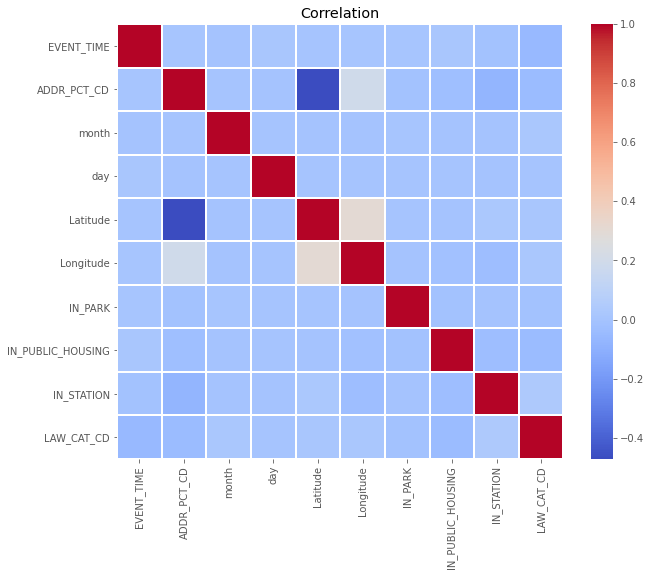

In [14]:
# Draw a corrolation matrix of the variables
corr = df_sel.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 2, linecolor = "white")
plt.title("Correlation")
plt.show()

### Deal with categorical data: pd.get_dummies()

In [15]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_sel)

df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451980 entries, 0 to 2451979
Data columns (total 35 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   EVENT_TIME                               int8   
 1   ADDR_PCT_CD                              float16
 2   month                                    int8   
 3   day                                      int8   
 4   Latitude                                 float16
 5   Longitude                                float16
 6   IN_PARK                                  int8   
 7   IN_PUBLIC_HOUSING                        int8   
 8   IN_STATION                               int8   
 9   LAW_CAT_CD                               int8   
 10  BORO_NM_BRONX                            uint8  
 11  BORO_NM_BROOKLYN                         uint8  
 12  BORO_NM_MANHATTAN                        uint8  
 13  BORO_NM_QUEENS                           uint8  
 14  BORO_NM_STATEN ISL

In [16]:
df_state_dummy.head()

,EVENT_TIME,ADDR_PCT_CD,month,day,Latitude,Longitude,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,LAW_CAT_CD,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_UNKNOWN,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,VIC_AGE_GROUP_UNKNOWN,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_UNKNOWN,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_SEX_D,VIC_SEX_E,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U
0,17,70.0,2,1,40.62500,-73.9375,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,68.0,9,27,40.62500,-74.0000,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,14,42.0,12,14,40.84375,-73.9375,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,14,122.0,8,13,40.59375,-74.0625,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,17,114.0,10,26,40.78125,-73.9375,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### Split the data into train and test

In [17]:
# Assign the data
df=df_state_dummy

# Set the target for the prediction
target='LAW_CAT_CD'

# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [18]:
y.unique()
y.value_counts()

1    817327
2    817327
0    817326
Name: LAW_CAT_CD, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=21, stratify=y)

## Utils

In [20]:
def plot_cm(y_pred,y_test,algorithm,figure_name):
    mat_RF = confusion_matrix(y_pred,y_test)
    plt.figure(figsize=(16,4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,xticklabels=[0,1,2],yticklabels=[0,1,2])
    plt.xlabel('True labels')
    plt.ylabel('predicted labels')
    plt.title(algorithm)
    plt.savefig(figure_name)

In [21]:
def plot_roc(y_test, model, figure_name):
    pl = skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), figsize=(12,6))
    plt.show()
    pl.figure.savefig(figure_name)

In [22]:
def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

## Modeling: Random Forest

In [23]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=1)

#Train the model using the training sets
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Get the accuracy score
acc_rf = accuracy_score(y_test, y_pred)

# Get classification report
class_report = classification_report(y_test, y_pred)

# Model Accuracy, how often is the classifier correct?
print("[Random forest algorithm] accuracy_score: {:.3f}.".format(acc_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.0s finished


[Random forest algorithm] accuracy_score: 0.449.


In [28]:
print(class_report)

              precision    recall  f1-score   support

           0       0.48      0.55      0.51    163465
           1       0.44      0.39      0.42    163465
           2       0.42      0.40      0.41    163466

    accuracy                           0.45    490396
   macro avg       0.45      0.45      0.45    490396
weighted avg       0.45      0.45      0.45    490396



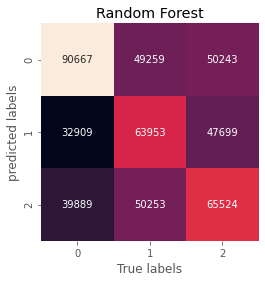

In [24]:
# Plot confusion matrix
plot_cm(y_pred,y_test,"Random Forest","cm_random_forest.pdf")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   37.6s finished


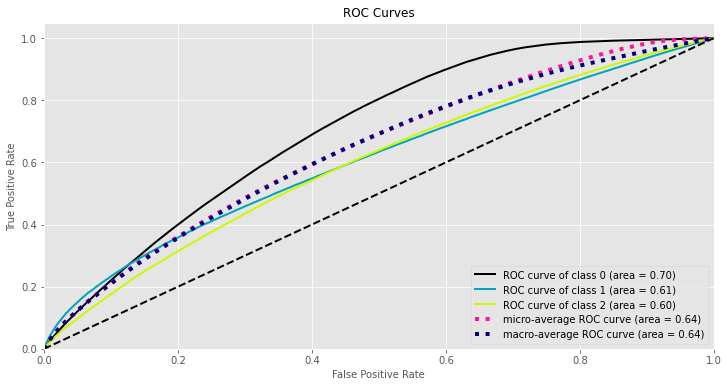

In [25]:
# Plot ROC curve
plot_roc(y_test,clf,"roc_random_forest.pdf")

In [26]:
# Save model
save_model(clf,"random_forest",True)

Model size: 125.42 MB


## Modeling: LightGBM

In [30]:
# Define the model hyperparameters
lgbm_params = {
          "boosting_type": "gbdt",
          "learning_rate": 0.1,
          "num_leaves": 20,
          "max_bin": 256,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9}
# Train the model
lbm_clf = lgbm.LGBMClassifier(**lgbm_params)
lbm_clf.fit(X_train,y_train)
# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)

# Get classification report
class_report = classification_report(y_test, y_pred)

print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1961584, number of used features: 34
[LightGBM] [Info] Start training from score -1.098613
[LightGBM] [Info] Start training from score -1.098611
[LightGBM] [Info] Start training from score -1.098613


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.6s finished


LightGBM Model accuracy score: 0.4489


In [31]:
print(class_report)

              precision    recall  f1-score   support

           0       0.48      0.55      0.51    163465
           1       0.44      0.39      0.42    163465
           2       0.42      0.40      0.41    163466

    accuracy                           0.45    490396
   macro avg       0.45      0.45      0.45    490396
weighted avg       0.45      0.45      0.45    490396



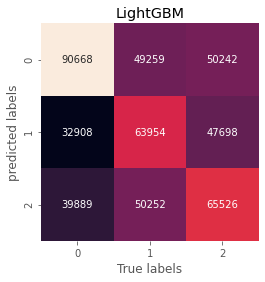

In [32]:
# Plot the confusion matrix
plot_cm(y_pred, y_test, "LightGBM", 'cm_LightGBM.pdf')

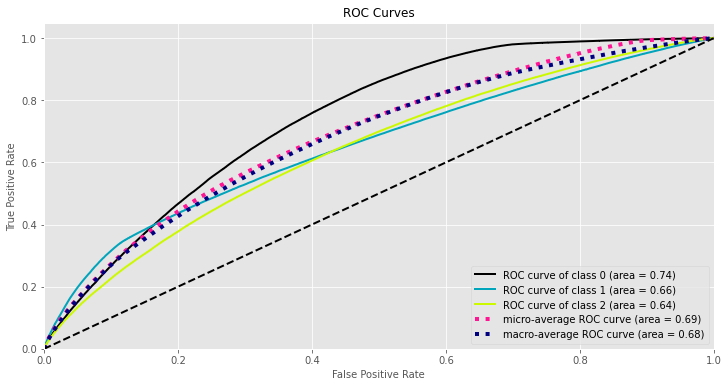

In [34]:
# Plot the ROC curve
plot_roc(y_test, lbm_clf, "roc_LightGBM.pdf")

In [35]:
# Save the model
save_model(lbm_clf, "lightgbm")

Model size: 0.68 MB


## Modeling XGBoost

In [36]:
# Before training the model, we need to remove some special characters from the columns name
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [37]:
# Define the model hyperparameters
params = {
            'objective':'multi:softmax',
            'max_depth': 10,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100,
            'use_label_encoder':False
        }

# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# test the models performace
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('XGBBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

[14:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBBoost Model accuracy score: 0.5040


In [38]:
# Get classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.49      0.76      0.60    163465
           1       0.59      0.35      0.44    163465
           2       0.47      0.40      0.43    163466

    accuracy                           0.50    490396
   macro avg       0.52      0.50      0.49    490396
weighted avg       0.52      0.50      0.49    490396



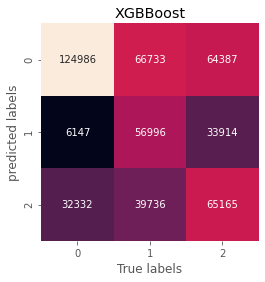

In [39]:
# Plot the confusion matrix
plot_cm(y_pred, y_test, "XGBBoost", 'cm_XGBBoost.pdf')

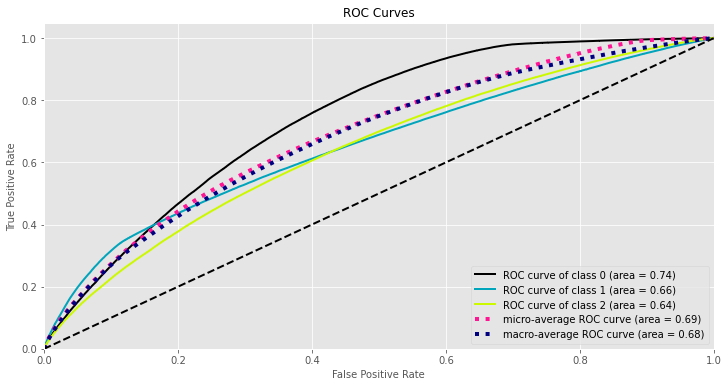

In [40]:
# Plot the ROC curve
plot_roc(y_test, lbm_clf, "roc_XGBBoost.pdf")

In [41]:
# Save the model
save_model(xgb_clf, "xgboost")

Model size: 16.52 MB
